# 环境

In [ ]:
import os
import time

import matplotlib.pylab as plt
import numpy as np
from scipy.io import wavfile
from silero_vad import load_silero_vad, get_speech_timestamps, VADIterator
# from ten_vad import TenVad
import torch
import tqdm

def calculate_db(chunk):
    rms = np.sqrt(np.mean(np.square(chunk)))
    return 20 * np.log10(rms + 1e-7) if rms > 0 else -np.inf

model = load_silero_vad(onnx=True)
prob_model = load_silero_vad(onnx=True)
SAMPLING_RATE = 16000
window_size_samples = 512 if SAMPLING_RATE == 16000 else 256
# ten_vad_instance = TenVad(window_size_samples, 0.5)

WAV_DIR_PATH = 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records'
WAV_FILES = filter(lambda x: not x.startswith('.'), os.listdir(WAV_DIR_PATH))
WAV_PATHS = [os.path.join(WAV_DIR_PATH, e) for e in sorted(WAV_FILES)]
WAV_PATHS

['exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-01-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-06-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-11-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-16-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-21-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-26-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-31-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-36-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/equidistant_audio_records/2025-08-15_17-58-41-611_5s_80000samples.wav',
 'exp_data/2025-08-15_17-58-01-417/eq

# 流式VAD样例

In [ ]:
vad_iterator = VADIterator(model, sampling_rate=SAMPLING_RATE)
vad_sec_iterator = VADIterator(model, sampling_rate=SAMPLING_RATE)
speech_probs = []
# ten_probs = []
wavs = []
# ten_wavs = []
for path in WAV_PATHS:
    sample_rate, wav = wavfile.read(path)
    # ten_wavs.append(wav)

    # 转换为float32并归一化
    if wav.dtype == np.int16:
        wav = wav.astype(np.float32) / 32768.0
    elif wav.dtype == np.float32:
        pass
    else:
        raise NotImplementedError('不被支持的数据类型')
    
    wav = torch.from_numpy(wav)
    # speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=SAMPLING_RATE)
    # print(speech_timestamps)
    # print(wav.dtype, wav.shape)
    wavs.append(wav)
wav = torch.concat(wavs)
# ten_wav = np.concatenate(ten_wavs)

dbs = []
# for i in tqdm.trange(0, len(wav), window_size_samples):
temp_ts = time.time()
time_gaps = []
for i in range(0, len(wav), window_size_samples):
    time_gaps.append(time.time()-temp_ts)
    temp_ts = time.time()
    chunk = wav[i: i+ window_size_samples]
    # ten_chunk = ten_wav[i: i+ window_size_samples]

    int_chunk = chunk.numpy() * 32767
    db = calculate_db(int_chunk)
    dbs.append(db)

    if len(chunk) < window_size_samples:
        break
    speech_dict = vad_iterator(chunk)
    if speech_dict:
        print(speech_dict)
        # vad_iterator.reset_states() # reset model states after each audio, but 和不重置的效果不一致
    speech_dict = vad_sec_iterator(chunk, return_seconds=True)
    if speech_dict:
        print(speech_dict)
        # vad_iterator.reset_states() # reset model states after each audio, but 和不重置的效果不一致
        
    speech_prob = prob_model(chunk, SAMPLING_RATE).item()
    speech_probs.append(speech_prob)
    # out_probability, _ = ten_vad_instance.process(ten_chunk)
    # ten_probs.append(out_probability)

{'start': 30752}
{'start': 1.9}
{'end': 2.4}
{'end': 38368}
{'start': 291872}
{'start': 18.2}
{'end': 18.9}
{'start': 19.1}
{'end': 320992}
{'end': 20.1}
{'start': 441376}
{'start': 27.6}
{'end': 27.9}
{'end': 446432}
{'start': 448544}
{'start': 28.0}
{'end': 28.2}
{'end': 452064}
{'start': 473632}
{'start': 29.6}
{'end': 29.8}
{'end': 477152}
{'start': 478752}
{'start': 29.9}
{'end': 30.1}
{'end': 482272}
{'start': 709152}
{'start': 44.3}
{'end': 725984}
{'end': 45.4}
{'start': 56.3}
{'end': 56.4}
{'start': 944160}
{'start': 59.0}
{'end': 59.1}
{'end': 946656}
{'start': 59.3}
{'start': 949280}
{'end': 950752}
{'end': 59.4}
{'start': 1040928}
{'start': 65.1}
{'end': 66.3}
{'end': 1061856}


## 人声概率在时间上分布

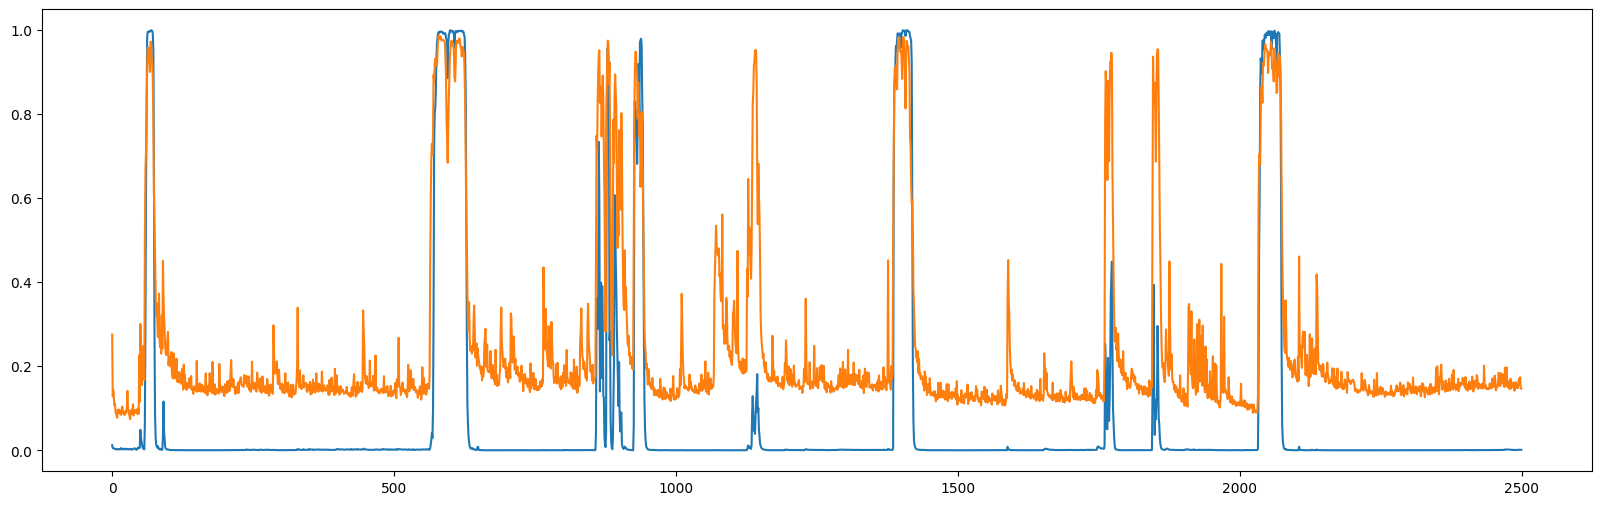

概率列表长度：2500


In [ ]:
plt.figure(figsize=(20,6))
plt.plot(speech_probs)
# plt.plot(ten_probs)
plt.show()
print(f'概率列表长度：{len(speech_probs)}')

# print(speech_probs[:10])
# print(speech_probs[-10:])

## 分贝数
看来啸叫噪音不一定比原语音分贝低

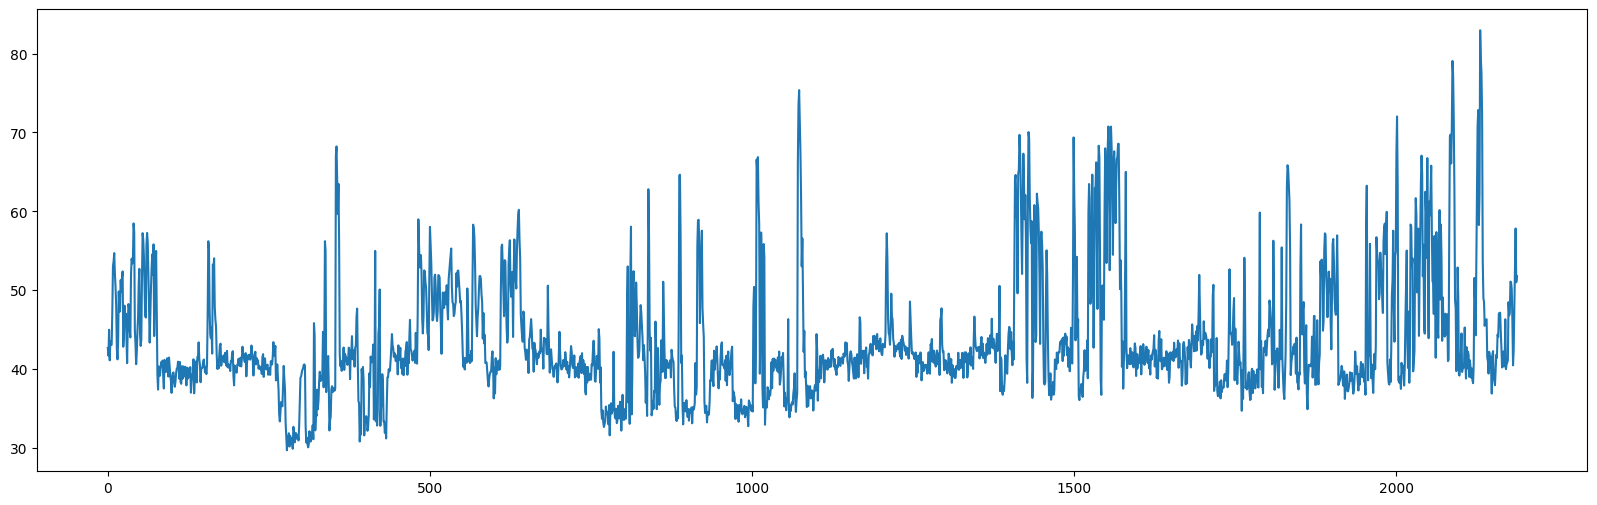

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(dbs)
plt.show()

## 延迟统计
< 1.2ms

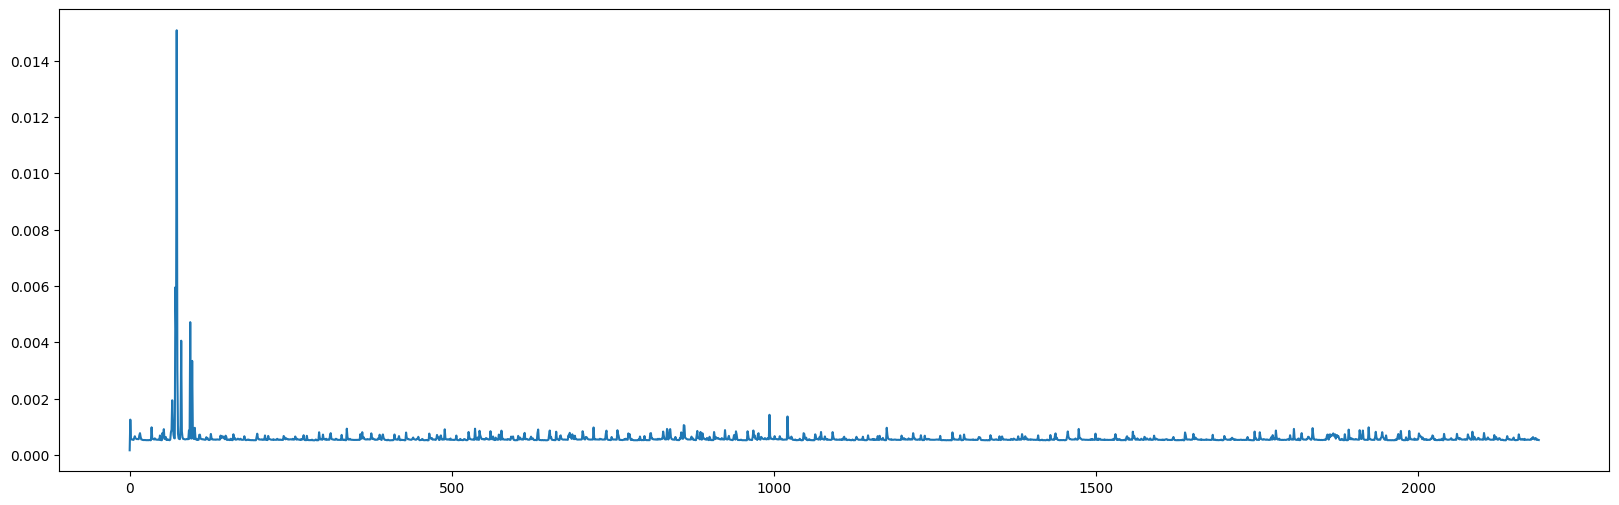

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(time_gaps)
plt.show()

In [ ]:
sum(time_gaps)

1.2825582027435303